# Обработка пропусков и выбросов в процессе первичного анализа статистики

### Disclaimer: 
_Представленные ниже примеры предназначены исключительно для демонстрации подходов к устранению аномалий в данных. Выбор подхода в "боевых условиях" должен осуществляеться в соответсвии с решаемыми задачами и с учетом особенностей формирования данных в исследуемом процессе_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [2]:
data = pd.read_csv("iris.csv")
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


### Добавляем немного NaN

In [3]:
data["petal.width"].iloc[145:149] = None
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,NaN,Virginica
148,6.2,3.4,5.4,NaN,Virginica
149,5.9,3.0,5.1,1.8,Virginica


## Построение гистограммы "petal.length"

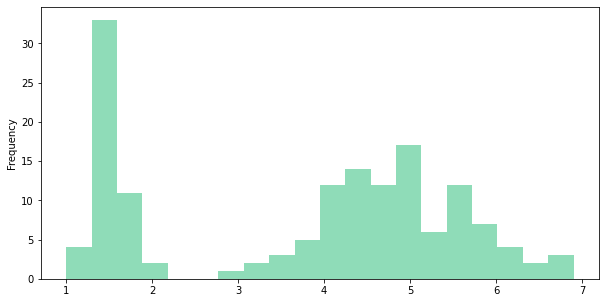

In [4]:
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Есть выброс "petal.length" в диапазоне примерно 1..1.9

### Зафиксируем исходные данные до заполнения NaN 

In [5]:
with_outliers = data["petal.length"].head(20).copy()
before_NaN = data["petal.width"].iloc[25:42].copy()

### Заменяем  выброс "petal.length" расчетными данными

#### длина лепестка не может быть отрицательной!

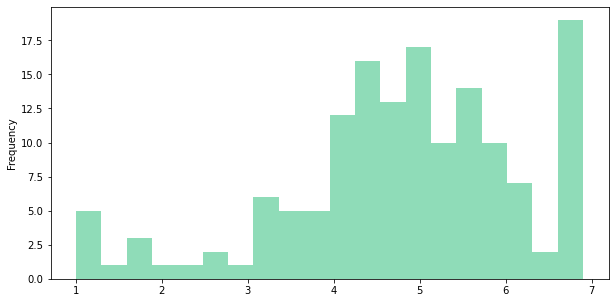

In [6]:
data["petal.length"][data["petal.length"]<=2.8] = np.clip(np.random.normal(loc= data["petal.length"][data["petal.length"]>=2.8].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]<=2.8])), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [7]:
### снова выбросы :-(
### убираем выброс минимумов ...

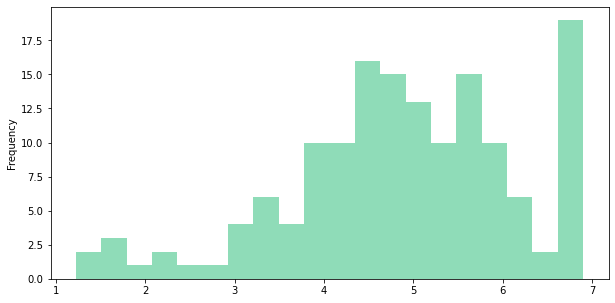

In [8]:
data["petal.length"][data["petal.length"]==data["petal.length"].min()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].min()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())



data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### ... и убираем выброс максимумов 

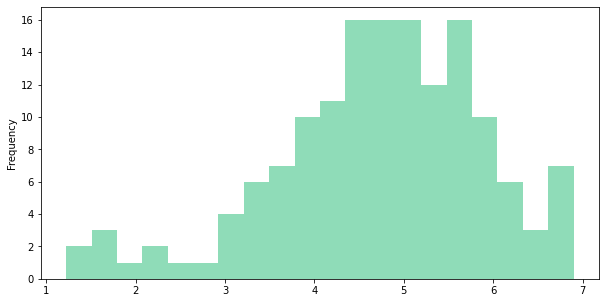

In [9]:
data["petal.length"][data["petal.length"]==data["petal.length"].max()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].max()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [10]:
display(pd.DataFrame(list(zip(with_outliers, data["petal.length"].head(20))),
                   columns=["With_outliers", "After_norm"]))

,With_outliers,After_norm
0,1.4,1.295704
1,1.4,2.119015
2,1.3,5.726110
3,1.5,2.274185
4,1.4,6.404103
5,1.7,6.160700
6,1.4,6.785477
7,1.5,5.642773
8,1.4,1.715080
9,1.5,6.041882


###### Выброс исчез

## Построение гистограмы для "petal.width"

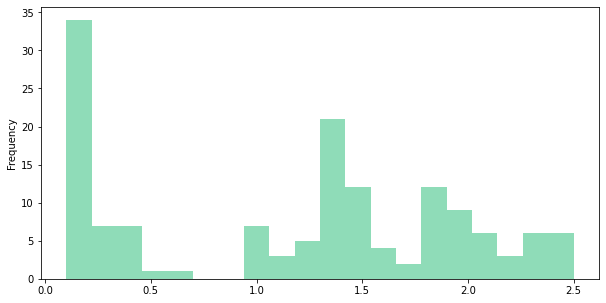

In [11]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### убеждаемся в наличии NaN

In [12]:
data["petal.width"][data["petal.width"].isnull()]

145   NaN
146   NaN
147   NaN
148   NaN
Name: petal.width, dtype: float64

### Заполняем пропуски

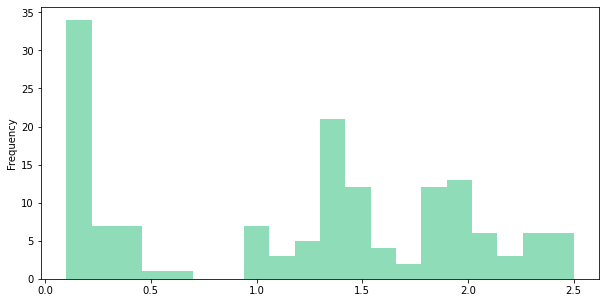

In [13]:
# используем std()
data["petal.width"].fillna(data["petal.width"].mean() 
                           + data["petal.width"].std()*np.random.randint(low=-1, high=2, size=1)[0], # ограничиваем отклонение
                          inplace=True)
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [14]:
data["petal.width"].tail(7)

143    2.300000
144    2.500000
145    1.930193
146    1.930193
147    1.930193
148    1.930193
149    1.800000
Name: petal.width, dtype: float64

### добавим еще пропусков (примерно 1/6)
### и проверим результаты по критерию $\chi^2$

array([21.,  5.,  5.,  1.,  1.,  0.,  0.,  7.,  3.,  5., 20., 11.,  3.,
        2.,  7., 11.,  5.,  2.,  5.,  5.])

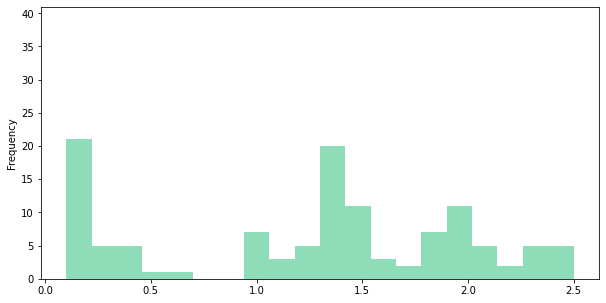

In [15]:
data["petal.width"].iloc[125:139] = None
data["petal.width"].iloc[25:42] = None
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

# фиксируем значения гистограммы (с разными BINS)
b_before, n_before, _ = plt.hist(data["petal.width"], bins=20, visible=False);
b2 = 5
b_before_2, n_before_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

# значения столбиков гистограммы
b_before

In [16]:
data["petal.width"].iloc[25:42]

25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: petal.width, dtype: float64

### Подготовка корректирующих значений

In [17]:
df_corr = pd.DataFrame(np.random.normal(loc=data["petal.width"].mean(),
                                scale=data["petal.width"].var(), 
                                size=len(data["petal.width"])),
                      columns = ["petal.width"]) 
                                
df_corr                      

,petal.width
0,-0.169920
1,0.477867
2,0.992478
3,0.774635
4,1.505386
...,...
145,0.839562
146,0.602686
147,1.276525
148,1.047119


In [18]:
df_corr.min() # больше нуля :-)

petal.width   -0.16992
dtype: float64

### Заполняем пропуски

In [19]:
data.fillna(value=df_corr, inplace=True)
display(pd.DataFrame(list(zip(before_NaN, data["petal.width"].iloc[25:42])),
                   columns=["before_set_NaN", "After_filling"]))

,before_set_NaN,After_filling
0,0.2,1.781956
1,0.4,1.676293
2,0.2,1.898246
3,0.2,1.859426
4,0.2,1.226347
5,0.2,2.060016
6,0.4,0.767058
7,0.1,0.620853
8,0.2,1.249229
9,0.2,1.549283


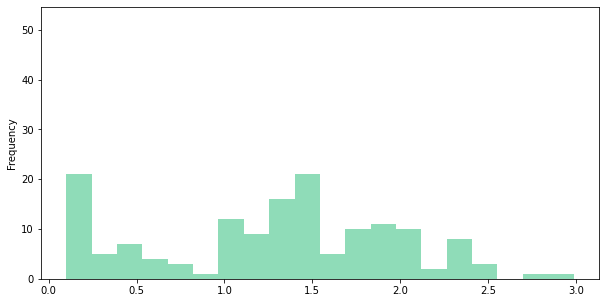

In [20]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20, );
# получаем параметры гистограммы c bins = 20
b_after, n_after, _ = plt.hist(data["petal.width"], bins=20, visible=False);
# и bins = 10
b_after_2, n_after_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

### Почти похоже на исходный :-)

#### ... но так ли это
#### используем критерий $\chi^2$

In [21]:
import scipy
scipy.__version__

'1.8.1'

In [29]:
# сравниваем методом хи-квадрат
from scipy.stats import chisquare, chi2_contingency
print (f"ДО\n {b_before} \nПОСЛЕ\n {b_after}")
#_, p_value = chisquare(b_before, b_after, ddof=len(b_after)-1)
stat, p_value, dof, _= chi2_contingency([b_before, b_after])
print(f"p_value = {p_value}")

ДО
 [21.  5.  5.  1.  1.  0.  0.  7.  3.  5. 20. 11.  3.  2.  7. 11.  5.  2.
  5.  5.] 
ПОСЛЕ
 [21.  5.  7.  4.  3.  1. 12.  9. 16. 21.  5. 10. 11. 10.  2.  8.  3.  0.
  1.  1.]
p_value = 1.5943546587259072e-06


#### меняем bins

In [32]:
print (f"ДО\n {b_before_2} \nПОСЛЕ\n {b_after_2}")
stat, p_value_2, dof, _= chi2_contingency([b_before, b_after])
print(f"p_value = {p_value_2}")

ДО
 [32.  8. 39. 23. 17.] 
ПОСЛЕ
 [37. 25. 52. 31.  5.]
p_value = 1.5943546587259072e-06


#### _...нужен иной подход ?_


### Снова генерируем пропуски, но в этот раз удаляем 

In [33]:
data["petal.width"].iloc[125:147] = None
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
140,6.7,3.1,5.6,NaN,Virginica
141,6.9,3.1,5.1,NaN,Virginica
142,5.8,2.7,5.1,NaN,Virginica
143,6.8,3.2,5.9,NaN,Virginica
144,6.7,3.3,5.7,NaN,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,1.930193,Virginica
148,6.2,3.4,5.4,1.930193,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


In [34]:
data.dropna(inplace=True)
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
118,7.7,2.6,3.542637,2.300000,Virginica
119,6.0,2.2,5.000000,1.500000,Virginica
120,6.9,3.2,5.700000,2.300000,Virginica
121,5.6,2.8,4.900000,2.000000,Virginica
122,7.7,2.8,6.700000,2.000000,Virginica
123,6.3,2.7,4.900000,1.800000,Virginica
124,6.7,3.3,5.700000,2.100000,Virginica
147,6.5,3.0,5.200000,1.930193,Virginica
148,6.2,3.4,5.400000,1.930193,Virginica
149,5.9,3.0,5.100000,1.800000,Virginica


### "Пропали" все строки с пропусками

## Заполняем смешанные пропуски
#### ...но сначала их создадим ))

In [35]:
display(data.head())
data.iloc[0:3] = None
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.295704,0.2,Setosa
1,4.9,3.0,2.119015,0.2,Setosa
2,4.7,3.2,5.726110,0.2,Setosa
3,4.6,3.1,2.274185,0.2,Setosa
4,5.0,3.6,6.404103,0.2,Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,NaN,NaN,NaN,NaN,None
1,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,NaN,None
3,4.6,3.1,2.274185,0.2,Setosa
4,5.0,3.6,6.404103,0.2,Setosa


In [36]:
values = {"sepal.length": data["sepal.length"][data["variety"]=="Setosa"].mean(),
          "sepal.width": data["sepal.width"][data["variety"]=="Setosa"].mean(), 
          "petal.length": data["petal.length"][data["variety"]=="Setosa"].median(), 
          "petal.width": data["petal.width"][data["variety"]=="Setosa"].median(),
          "variety": "Setosa"}
data.fillna(value=values, inplace=True)
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.012766,3.440426,4.914888,0.394192,Setosa
1,5.012766,3.440426,4.914888,0.394192,Setosa
2,5.012766,3.440426,4.914888,0.394192,Setosa
3,4.600000,3.100000,2.274185,0.200000,Setosa
4,5.000000,3.600000,6.404103,0.200000,Setosa


## Extra case. Infinity

In [37]:
data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
data.iloc[15:19]

,sepal.length,sepal.width,petal.length,petal.width,variety
15,5.7,4.4,3.062185,inf,Setosa
16,5.4,3.9,5.302427,-inf,Setosa
17,5.1,3.5,4.978063,inf,Setosa
18,5.7,3.8,6.900000,-inf,Setosa


### Гистограмма не строится при наличии inf

In [38]:
data["petal.width"].describe()

count    128.000000
mean            NaN
std             NaN
min            -inf
25%        0.596635
50%        1.300000
75%        1.786467
max             inf
Name: petal.width, dtype: float64

In [39]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# Ой! Что-то пойшло не так!

ValueError: autodetected range of [-inf, inf] is not finite

## Заменяем inf и -inf на NaN

In [ ]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.iloc[14:20]

### а дальше дело техники...

# Устранение пропусков в линиях/рядах

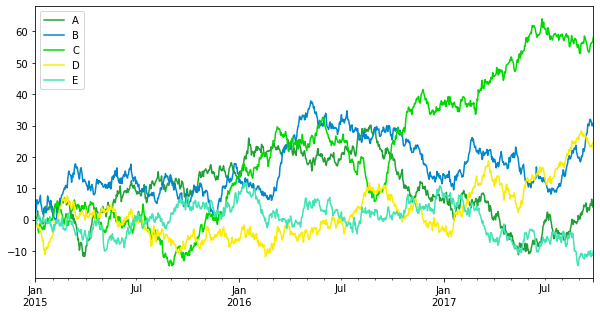

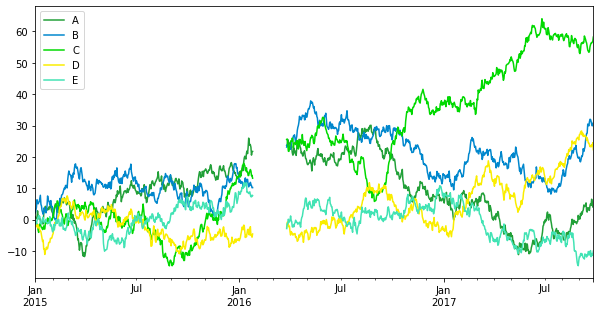

In [40]:
sbercolors = ['#21A038','#0087CD','#00D900', '#FAED00',  '#42E3B4','#21BA72'] 
image_params = dict(figsize=(10,5), 
                color=sbercolors)
samples = np.random.randn(1000, 5)

df = pd.DataFrame(samples, 
                   index=pd.date_range("1/1/2015", periods=1000),
                   columns=list("ABCDE"))
df = df.cumsum()
df.plot(**image_params);    
before = df.iloc[400:420].copy()        
df.iloc[390:450] = None

df.plot(**image_params);
  

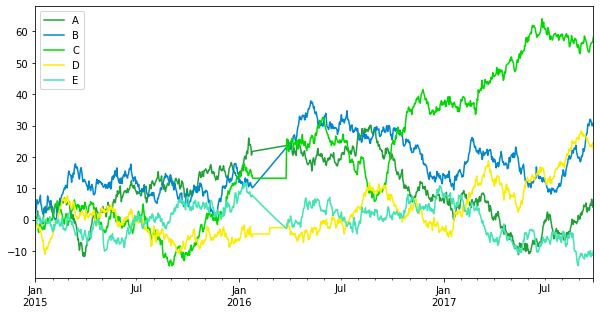

In [41]:
to_fill = {"A": df["A"].interpolate(method='linear'),
           "B": df["B"].interpolate(method='time'),
           "C": df["C"].interpolate(method='pad'),
           "D": df["D"].interpolate(method='nearest'),
           "E": df["E"].interpolate(method='akima'),}
df.fillna(value=to_fill, inplace=True)
df.plot(**image_params);


In [42]:
to_check = pd.concat((before,df.iloc[400:420]), axis=1)
to_check.columns = pd.MultiIndex.from_product([['Before', 'Recycled'], df.columns,],
                                     names=['subject', 'type'])

display(to_check) 

subject        Before                                              Recycled  \
type                A          B          C          D         E          A   
2016-02-05  22.722130  10.698341  16.970239  -8.399571  5.395405  22.087584   
2016-02-06  22.622392   9.549900  19.688943  -7.450786  6.278459  22.118478   
2016-02-07  22.212587   9.779597  19.613897  -7.408380  4.560532  22.149373   
2016-02-08  22.287575   9.849082  19.287903  -7.249251  4.269108  22.180267   
2016-02-09  21.291171   8.617546  19.558851  -8.464259  2.374512  22.211162   
2016-02-10  24.007369   8.665669  20.879460  -7.804680  1.968720  22.242056   
2016-02-11  23.498333   7.780160  20.074645  -7.668808  3.109098  22.272951   
2016-02-12  23.192093   9.026806  20.972230  -8.169094  2.414171  22.303845   
2016-02-13  23.273865   7.791931  21.443556  -8.696143  1.263614  22.334740   
2016-02-14  21.378275   7.541464  21.229234  -7.946468  1.126603  22.365634   
2016-02-15  20.269350   8.359360  21.060675  -9.338694  0.568844  22.396529   
2016-02-16  20.122102   8.566441  21.054664  -9.969826 -0.414865  22.427423   
2016-02-17  21.221940   7.714359  20.153137 -11.901354  0.367015  22.458318   
2016-02-18  21.219269   7.784479  20.871215 -11.428642 -1.310025  22.489212   
2016-02-19  21.692076   7.010181  21.346504 -11.123471 -1.427950  22.520107   
2016-02-20  21.743253   7.626499  20.005118  -9.885640 -2.538790  22.551001   
2016-02-21  21.912962   6.418540  18.691072  -9.366647 -0.988636  22.581896   
2016-02-22  21.763144   6.635789  16.883471 -10.494845 -1.723561  22.612790   
2016-02-23  21.721834   6.948549  18.146124 -10.712778 -0.538014  22.643685   
2016-02-24  22.052422   6.513044  19.278165 -10.648578  1.281293  22.674579   

subject                                              
type                B          C        D         E  
2016-02-05  12.523742  13.196145 -4.58854  5.603987  
2016-02-06  12.735726  13.196145 -4.58854  5.422346  
2016-02-07  12.947710  13.196145 -4.58854  5.241058  
2016-02-08  13.159693  13.196145 -4.58854  5.060133  
2016-02-09  13.371677  13.196145 -4.58854  4.879580  
2016-02-10  13.583661  13.196145 -4.58854  4.699407  
2016-02-11  13.795645  13.196145 -4.58854  4.519624  
2016-02-12  14.007629  13.196145 -4.58854  4.340239  
2016-02-13  14.219613  13.196145 -4.58854  4.161262  
2016-02-14  14.431597  13.196145 -4.58854  3.982702  
2016-02-15  14.643581  13.196145 -4.58854  3.804566  
2016-02-16  14.855564  13.196145 -4.58854  3.626865  
2016-02-17  15.067548  13.196145 -4.58854  3.449607  
2016-02-18  15.279532  13.196145 -4.58854  3.272802  
2016-02-19  15.491516  13.196145 -4.58854  3.096457  
2016-02-20  15.703500  13.196145 -4.58854  2.920583  
2016-02-21  15.915484  13.196145 -4.58854  2.745188  
2016-02-22  16.127468  13.196145 -4.58854  2.570281  
2016-02-23  16.339452  13.196145 -4.58854  2.395871  
2016-02-24  16.551435  13.196145 -4.58854  2.221967

#### Проверим точность восстановления по критерию $\chi^2$

In [71]:
for litera in "ABCDE":
    stat, p_value = chisquare([to_check["Before", litera].abs(), 
                               to_check["Recycled",litera].abs()])
    display(f"{litera}: {np.mean(p_value)}") 

'A: 0.8828484800985036'

'B: 0.2294652597104649'

'C: 0.25862733880506544'

'D: 0.24237917029490458'

'E: 0.4727338471848526'

#### или просто посчитаем погрешность

In [43]:
# set colors for min, max. average values
color_set = pd.DataFrame({"Colors":("MAX", "MIN", "AVERAGE")})

def highlight_fill(s):
    colors =  ['background-color: #42E3B4',
            'background-color: #0087CD',
             'background-color: #FAED00']
    return [colors[0] if i==0 else  colors[1] if i==1 else colors[2] for i in range(len(s))]


color_set = color_set.style.apply(highlight_fill)
display(color_set)

# count accurancy values

accurancy = pd.concat( (before-df.iloc[400:420],
                       pow((before-df.iloc[400:420]),2)), axis=1) 
accurancy.columns = pd.MultiIndex.from_product([['ABS', 'SQR'], df.columns,],
                                     names=['subject', 'type'])
# adding a row
accurancy.loc[-1] = [accurancy[a_s].mean() for a_s in accurancy.columns[:5].tolist()] +\
                    [np.sqrt(accurancy[a_s].sum()/(len(accurancy)-1)) for a_s in accurancy.columns[5:].tolist()]  

def highlight_diff_max(s):
    if max(abs(s))==max(s): 
        idx = s.tolist().index(max(abs(s)))
    elif max(abs(s))!=max(s):
        idx = s.tolist().index(max(s))
    return ['background-color: #42E3B4' if i==idx else '' for i in range(len(s))]

def highlight_diff_min(s):
    if min(abs(s))==min(s): 
        idx = s.tolist().index(min(abs(s)))
    elif min(abs(s))!=min(s):
        idx = s.tolist().index(min(s))
    return ['background-color: #0087CD' if i==idx else '' for i in range(len(s))]

def highlight_last_row(s):
    return ['background-color: #FAED00' if i==len(s)-1 else '' for i in range(len(s))]

accurancy = accurancy.style.apply(highlight_last_row).apply(highlight_diff_max).apply(highlight_diff_min)
accurancy


,Colors
0,MAX
1,MIN
2,AVERAGE


### Красиво сохраняем...

In [95]:
type(accurancy)

pandas.io.formats.style.Styler

In [96]:
accurancy.to_excel("accurancy.xlsx") # xlsx only !!!!!!!!